The Time Series assignment focuses on building and evaluating recurrent neural networks (RNNs) for time-series forecasting using the Jena Climate dataset. Specifically, you aim to predict future temperatures by analyzing past weather data recorded every 10 minutes, including variables like temperature, humidity, and pressure.

	1.	Data Preprocessing: Load and normalize the dataset. Split it into training, validation, and test sets, ensuring the temporal order is maintained.
	2.	Baseline Comparison: Establish a simple baseline model by predicting the last observed temperature as the next, providing a benchmark for the RNN models.
	3.	RNN Models: Implement several RNN architectures, including:
	•	LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit), which are common for time-series due to their ability to capture long-term dependencies.
	•	Hybrid models like Conv1D + LSTM, combining convolutional and recurrent layers for local and temporal patterns.
	•	Bidirectional LSTM for capturing forward and backward dependencies in the data.
	4.	Evaluation and Visualization: Compare each model’s performance on the test set using MAE (Mean Absolute Error) and visualize predictions vs. actual values. Additionally, plot training and validation MAE across epochs to understand each model’s learning and generalization.


# Data Loading and Preprocessing:
Lets start by loading the data, normalizing it, and creating the training, validation, and test sets.

In [18]:
# 1: Essential Libraries

# Libraries for data handling and visualization
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt

# Load the dataset
fname = "jena_climate_2009_2016.csv"
data = pd.read_csv(fname)

# Parse the data
temperature = np.array(data["T (degC)"])
raw_data = data.drop(columns=["Date Time"]).values

# Train-validation-test split sizes
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

# Parameters for time-series dataset
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Creating time-series datasets
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)
# Print the first few rows of normalized data
print("First 5 rows of normalized data:")
print(raw_data[:5])

# Print the mean and standard deviation used for normalization
print("\nMean used for normalization:", mean)
print("Standard deviation used for normalization:", std)

# Print the shapes of training, validation, and test datasets
print("\nTraining dataset shape:", list(train_dataset.as_numpy_iterator())[0][0].shape)
print("Validation dataset shape:", list(val_dataset.as_numpy_iterator())[0][0].shape)
print("Test dataset shape:", list(test_dataset.as_numpy_iterator())[0][0].shape)

First 5 rows of normalized data:
[[ 0.91365151 -1.92064015 -1.97449272 -1.86625827  1.04801712 -1.29131928
  -1.46715535 -0.78234525 -1.47012583 -1.4720352   2.12415558 -0.73016651
  -0.77935289 -0.28119316]
 [ 0.91953033 -1.96510495 -2.01848295 -1.91992974  1.05403079 -1.30447494
  -1.48885833 -0.78444185 -1.48911721 -1.49346536  2.1729195  -0.93230685
  -0.88696976 -0.46989368]
 [ 0.91482727 -1.97650618 -2.0297625  -1.92416696  1.08409914 -1.30710607
  -1.49126977 -0.78653846 -1.49291549 -1.49584649  2.18338591 -1.27790162
  -1.26147647 -0.05638329]
 [ 0.91247574 -1.95370372 -2.00607545 -1.89026919  1.10214015 -1.30052824
  -1.47680112 -0.78863507 -1.47772238 -1.48155971  2.15840926 -1.18009178
  -1.31743724  0.25112867]
 [ 0.91247574 -1.94914323 -2.00269159 -1.88603197  1.09612648 -1.29921268
  -1.47438968 -0.78863507 -1.47772238 -1.47917858  2.15388968 -1.19313309
  -1.26147647  0.44099401]]

Mean used for normalization: [ 988.74929466    8.82590329  282.9050718     4.31331863   75

**Non-ML Baseline (Common-Sense Baseline)**

In [19]:
def evaluate_naive_baseline(dataset, std, mean):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE (Naive Baseline): {evaluate_naive_baseline(val_dataset, std, mean):.2f}")
print(f"Test MAE (Naive Baseline): {evaluate_naive_baseline(test_dataset, std, mean):.2f}")

Validation MAE (Naive Baseline): 2.44
Test MAE (Naive Baseline): 2.62


Dense model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - loss: 93.4816 - mae: 7.7245 - val_loss: 23.6090 - val_mae: 3.8381
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 23.2412 - mae: 3.8527 - val_loss: 20.5289 - val_mae: 3.5778
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 21.9914 - mae: 3.7460 - val_loss: 20.5719 - val_mae: 3.5821
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 21.7702 - mae: 3.7252 - val_loss: 20.6224 - val_mae: 3.5920
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - loss: 21.6005 - mae: 3.7101 - val_loss: 20.4822 - val_mae: 3.5760
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 21.4683 - mae: 3.6977 - val_loss: 20.4413 - val_mae: 3.5767
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 68ms/step - loss: 21.3751 - mae: 3.6900 - val_loss: 20.5664 - val_mae: 3.5902
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - loss: 21.3070 - mae: 3.6844 - val_loss: 20.5772 - val_mae: 3.5894
Epoch 9/10
819/819 ━━━━━

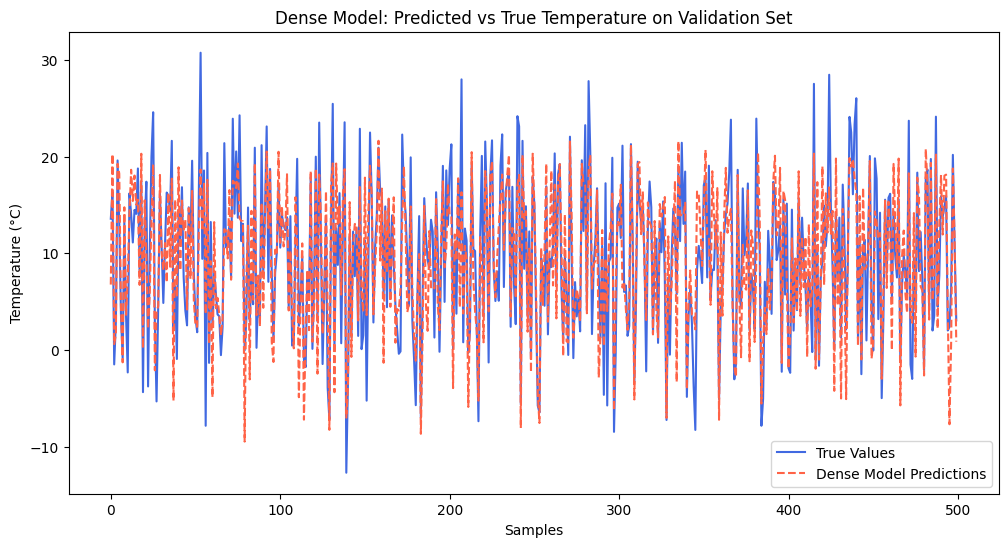

In [21]:
from tensorflow.keras import layers, models

# Define and train the Dense model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Replacing Flatten with GlobalAveragePooling1D
x = layers.GlobalAveragePooling1D()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
dense_model = models.Model(inputs, outputs)

dense_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_dense = dense_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for Dense model
y_val_true, y_val_pred_dense = [], []
for samples, targets in val_dataset.take(2):  # Subset of validation data
    y_val_true.extend(targets.numpy())
    y_val_pred_dense.extend(dense_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_dense[:500], label="Dense Model Predictions", color='tomato', linestyle='--')
plt.title("Dense Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# ** Standalone 1D Convolutional Model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 107ms/step - loss: 28.6611 - mae: 4.1621 - val_loss: 16.8022 - val_mae: 3.2151
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 15.8150 - mae: 3.1515 - val_loss: 14.5558 - val_mae: 3.0259
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - loss: 14.1156 - mae: 2.9740 - val_loss: 14.2328 - val_mae: 2.9960
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 110ms/step - loss: 13.2331 - mae: 2.8848 - val_loss: 15.2829 - val_mae: 3.0759
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 115ms/step - loss: 12.5844 - mae: 2.8123 - val_loss: 14.5280 - val_mae: 2.9955
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 114ms/step - loss: 12.0762 - mae: 2.7527 - val_loss: 15.2378 - val_mae: 3.0759
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 110ms/step - loss: 11.6393 - mae: 2.7029 - val_loss: 14.2450 - val_mae: 2.9643
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 135ms/step - loss: 11.2882 - mae: 2.6597 - val_loss: 14.8251 - val_mae: 3.0369
Epoch 9/10
81

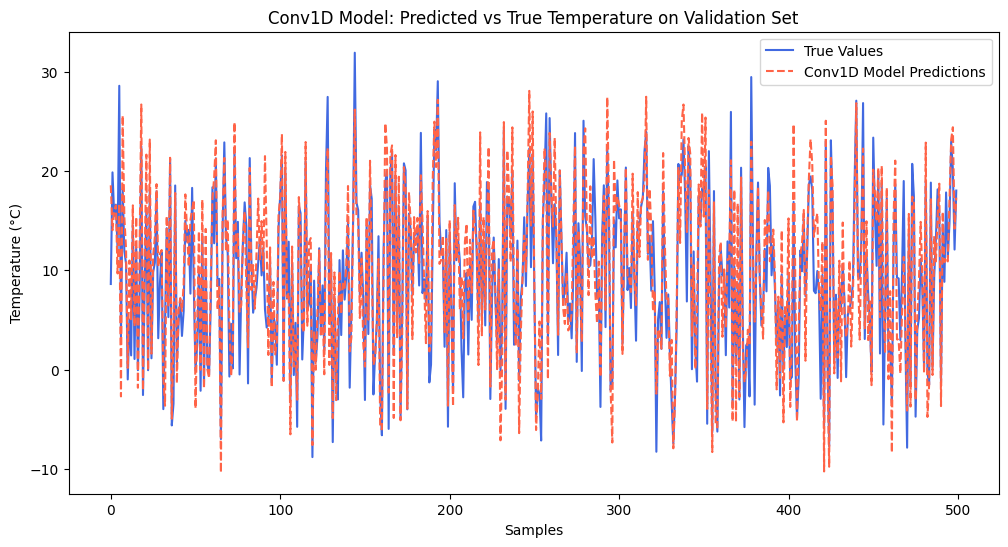

In [22]:
# Define and train the Conv1D model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
conv_model = models.Model(inputs, outputs)

conv_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_conv = conv_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for Conv1D model
y_val_true, y_val_pred_conv = [], []
for samples, targets in val_dataset.take(2):
    y_val_true.extend(targets.numpy())
    y_val_pred_conv.extend(conv_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_conv[:500], label="Conv1D Model Predictions", color='tomato', linestyle='--')
plt.title("Conv1D Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**LSTM model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 142ms/step - loss: 63.7481 - mae: 6.0822 - val_loss: 11.7108 - val_mae: 2.6341
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - loss: 11.5053 - mae: 2.6308 - val_loss: 9.6164 - val_mae: 2.4211
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 123s 140ms/step - loss: 10.0515 - mae: 2.4745 - val_loss: 10.1187 - val_mae: 2.4643
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 9.6514 - mae: 2.4246 - val_loss: 10.3963 - val_mae: 2.4934
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 146ms/step - loss: 9.3654 - mae: 2.3837 - val_loss: 10.2491 - val_mae: 2.4735
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 9.1425 - mae: 2.3497 - val_loss: 10.2030 - val_mae: 2.4719
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 158ms/step - loss: 8.9687 - mae: 2.3234 - val_loss: 10.3158 - val_mae: 2.4851
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 8.7585 - mae: 2.2938 - val_loss: 10.4109 - val_mae: 2.5014
Epoch 9/10
819

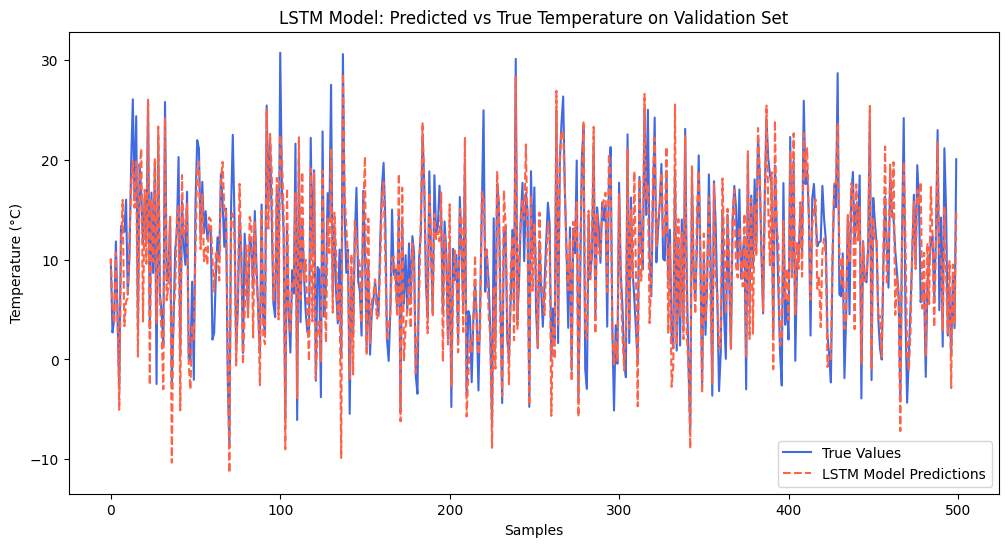

In [23]:
# Define and train the LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
lstm_model = models.Model(inputs, outputs)

lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_lstm = lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for LSTM model
y_val_true, y_val_pred_lstm = [], []
for samples, targets in val_dataset.take(2):
    y_val_true.extend(targets.numpy())
    y_val_pred_lstm.extend(lstm_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_lstm[:500], label="LSTM Model Predictions", color='tomato', linestyle='--')
plt.title("LSTM Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**GRU model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 157s 167ms/step - loss: 69.4883 - mae: 6.3424 - val_loss: 12.2951 - val_mae: 2.6407
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 155s 189ms/step - loss: 10.9835 - mae: 2.5728 - val_loss: 9.7823 - val_mae: 2.4056
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 166ms/step - loss: 9.5225 - mae: 2.4103 - val_loss: 9.4796 - val_mae: 2.3739
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 166ms/step - loss: 9.1632 - mae: 2.3604 - val_loss: 9.4463 - val_mae: 2.3741
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 8.9549 - mae: 2.3338 - val_loss: 9.4095 - val_mae: 2.3721
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 8.8175 - mae: 2.3147 - val_loss: 9.7613 - val_mae: 2.4112
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 8.6902 - mae: 2.2981 - val_loss: 9.8379 - val_mae: 2.4158
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 170ms/step - loss: 8.5885 - mae: 2.2858 - val_loss: 9.7033 - val_mae: 2.4025
Epoch 9/10
819/819 ━━

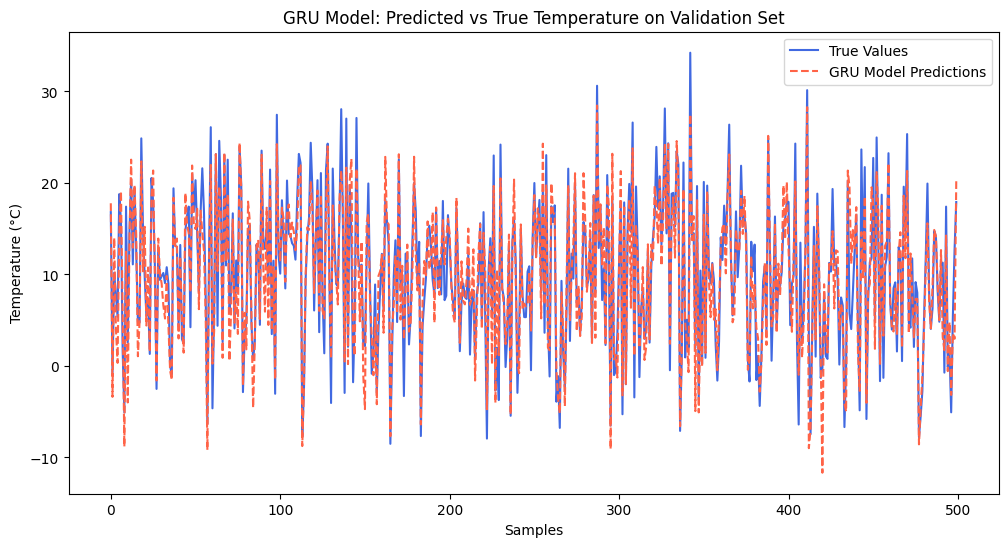

In [25]:
# Define and train the GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
gru_model = models.Model(inputs, outputs)

gru_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_gru = gru_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for GRU model
y_val_true, y_val_pred_gru = [], []
for samples, targets in val_dataset.take(2):
    y_val_true.extend(targets.numpy())
    y_val_pred_gru.extend(gru_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_gru[:500], label="GRU Model Predictions", color='tomato', linestyle='--')
plt.title("GRU Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**Conv1D + LSTM model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - loss: 78.0971 - mae: 6.8019 - val_loss: 14.3043 - val_mae: 2.8341
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 133ms/step - loss: 12.1936 - mae: 2.6913 - val_loss: 10.0223 - val_mae: 2.4813
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 130ms/step - loss: 9.3993 - mae: 2.4037 - val_loss: 10.1940 - val_mae: 2.5156
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 132ms/step - loss: 8.6687 - mae: 2.3116 - val_loss: 10.4365 - val_mae: 2.5460
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - loss: 8.1841 - mae: 2.2451 - val_loss: 11.3927 - val_mae: 2.6709
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - loss: 7.8207 - mae: 2.1970 - val_loss: 11.0307 - val_mae: 2.6276
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - loss: 7.5037 - mae: 2.1514 - val_loss: 11.5595 - val_mae: 2.6889
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 133ms/step - loss: 7.2601 - mae: 2.1164 - val_loss: 12.5130 - val_mae: 2.7961
Epoch 9/10
819

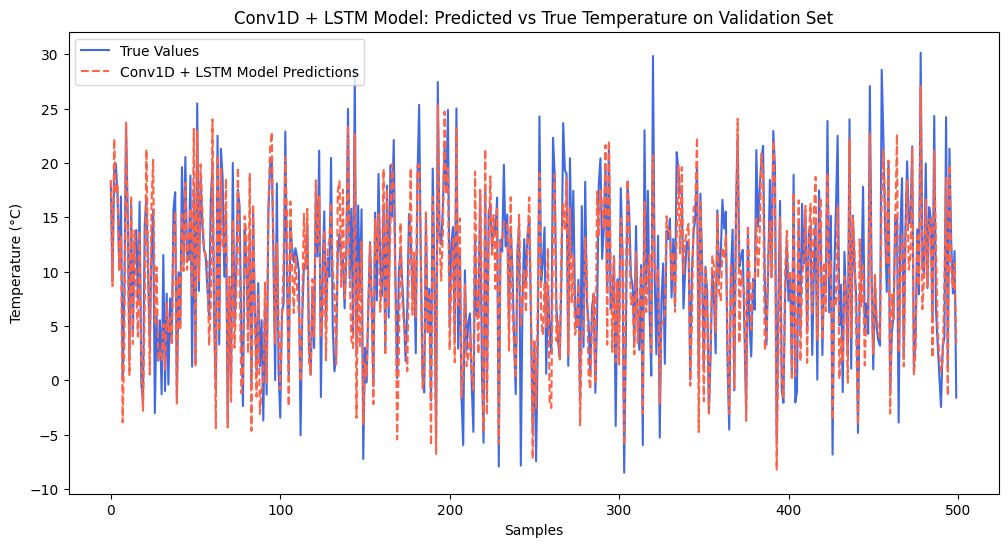

In [26]:
# Define and train the Conv1D + LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
conv1d_lstm_model = models.Model(inputs, outputs)

conv1d_lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_conv1d_lstm = conv1d_lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for Conv1D + LSTM model
y_val_true, y_val_pred_conv1d_lstm = [], []
for samples, targets in val_dataset.take(2):
    y_val_true.extend(targets.numpy())
    y_val_pred_conv1d_lstm.extend(conv1d_lstm_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_conv1d_lstm[:500], label="Conv1D + LSTM Model Predictions", color='tomato', linestyle='--')
plt.title("Conv1D + LSTM Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**Bidirectional LSTM Model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 164s 195ms/step - loss: 50.7737 - mae: 5.2278 - val_loss: 10.7223 - val_mae: 2.5423
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 202s 195ms/step - loss: 9.8518 - mae: 2.4561 - val_loss: 9.5290 - val_mae: 2.4037
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 169s 206ms/step - loss: 8.7384 - mae: 2.3011 - val_loss: 9.7805 - val_mae: 2.4154
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 164s 200ms/step - loss: 8.0820 - mae: 2.2146 - val_loss: 9.9646 - val_mae: 2.4437
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 165s 201ms/step - loss: 7.7019 - mae: 2.1616 - val_loss: 10.1316 - val_mae: 2.4596
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 200s 199ms/step - loss: 7.2939 - mae: 2.1069 - val_loss: 10.1611 - val_mae: 2.4581
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 162s 197ms/step - loss: 7.0312 - mae: 2.0712 - val_loss: 10.6799 - val_mae: 2.5261
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 160s 195ms/step - loss: 6.7691 - mae: 2.0308 - val_loss: 10.7463 - val_mae: 2.5346
Epoch 9/10
819/819

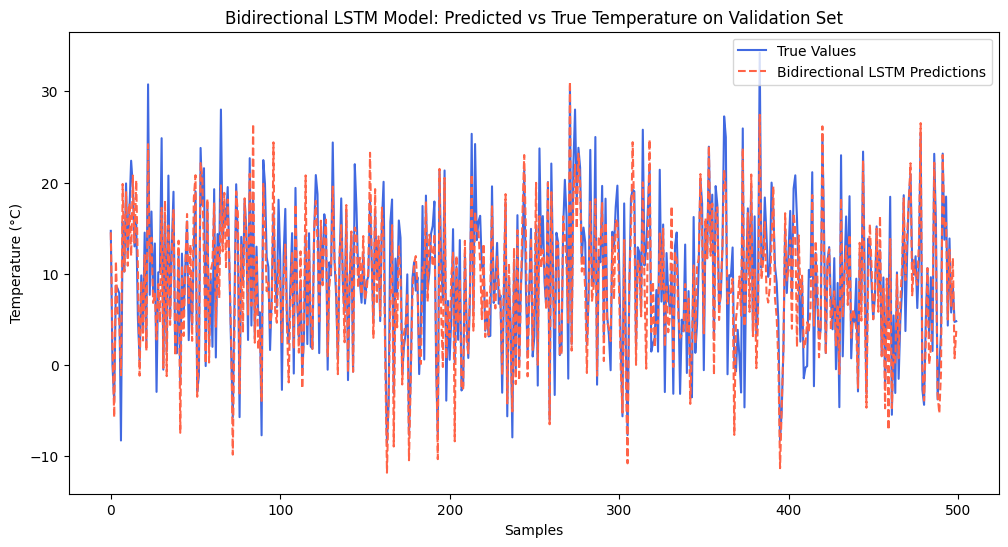

In [27]:
# Define and train the Bidirectional LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
bidir_lstm_model = models.Model(inputs, outputs)

bidir_lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_bidir_lstm = bidir_lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions and plot for Bidirectional LSTM model
y_val_true, y_val_pred_bidir_lstm = [], []
for samples, targets in val_dataset.take(2):
    y_val_true.extend(targets.numpy())
    y_val_pred_bidir_lstm.extend(bidir_lstm_model.predict(samples).squeeze())

plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:500], label="True Values", color='royalblue')
plt.plot(y_val_pred_bidir_lstm[:500], label="Bidirectional LSTM Predictions", color='tomato', linestyle='--')
plt.title("Bidirectional LSTM Model: Predicted vs True Temperature on Validation Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**Final Visualizations**
1. Training and Validation MAE Over Epochs for All Models

This plot combines the training and validation MAE over epochs for each model, giving a side-by-side view of how well each model learned and generalized over time.

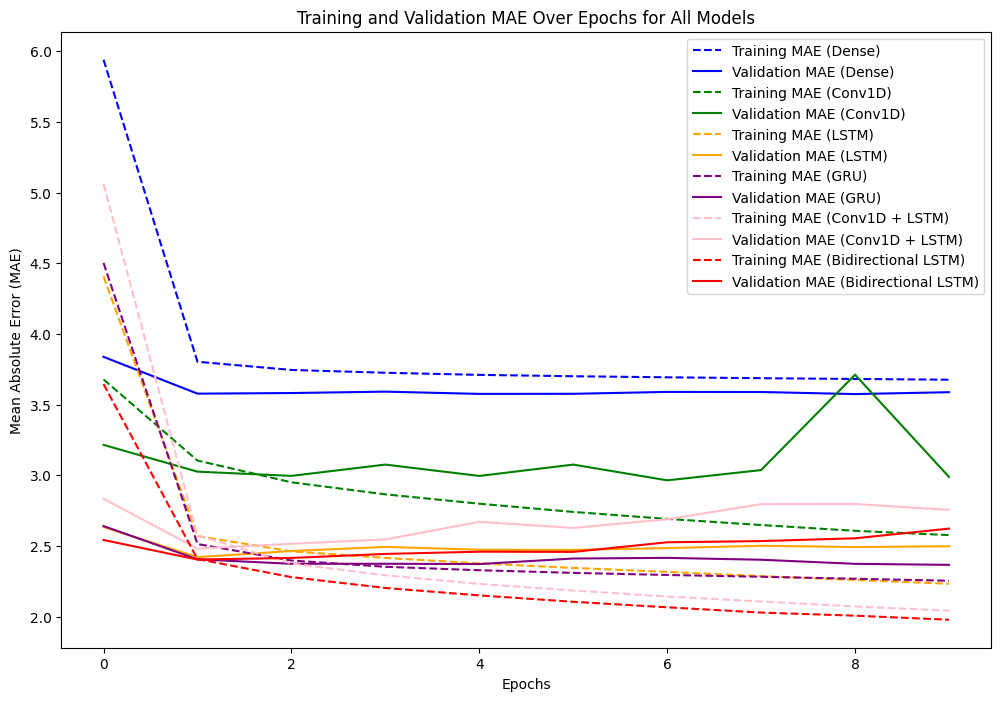

In [29]:
plt.figure(figsize=(12, 8))

# Dense Model
plt.plot(history_dense.history['mae'], label='Training MAE (Dense)', color='blue', linestyle='--')
plt.plot(history_dense.history['val_mae'], label='Validation MAE (Dense)', color='blue')

# Conv1D Model
plt.plot(history_conv.history['mae'], label='Training MAE (Conv1D)', color='green', linestyle='--')
plt.plot(history_conv.history['val_mae'], label='Validation MAE (Conv1D)', color='green')

# LSTM Model
plt.plot(history_lstm.history['mae'], label='Training MAE (LSTM)', color='orange', linestyle='--')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE (LSTM)', color='orange')

# GRU Model
plt.plot(history_gru.history['mae'], label='Training MAE (GRU)', color='purple', linestyle='--')
plt.plot(history_gru.history['val_mae'], label='Validation MAE (GRU)', color='purple')

# Conv1D + LSTM Model
plt.plot(history_conv1d_lstm.history['mae'], label='Training MAE (Conv1D + LSTM)', color='pink', linestyle='--')
plt.plot(history_conv1d_lstm.history['val_mae'], label='Validation MAE (Conv1D + LSTM)', color='pink')

# Bidirectional LSTM Model
plt.plot(history_bidir_lstm.history['mae'], label='Training MAE (Bidirectional LSTM)', color='red', linestyle='--')
plt.plot(history_bidir_lstm.history['val_mae'], label='Validation MAE (Bidirectional LSTM)', color='red')

plt.title("Training and Validation MAE Over Epochs for All Models")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

2. Bar Chart for Final Test MAE Comparison

This bar chart will provide a quick visual comparison of each model’s Test MAE. Lower bars indicate better performance.

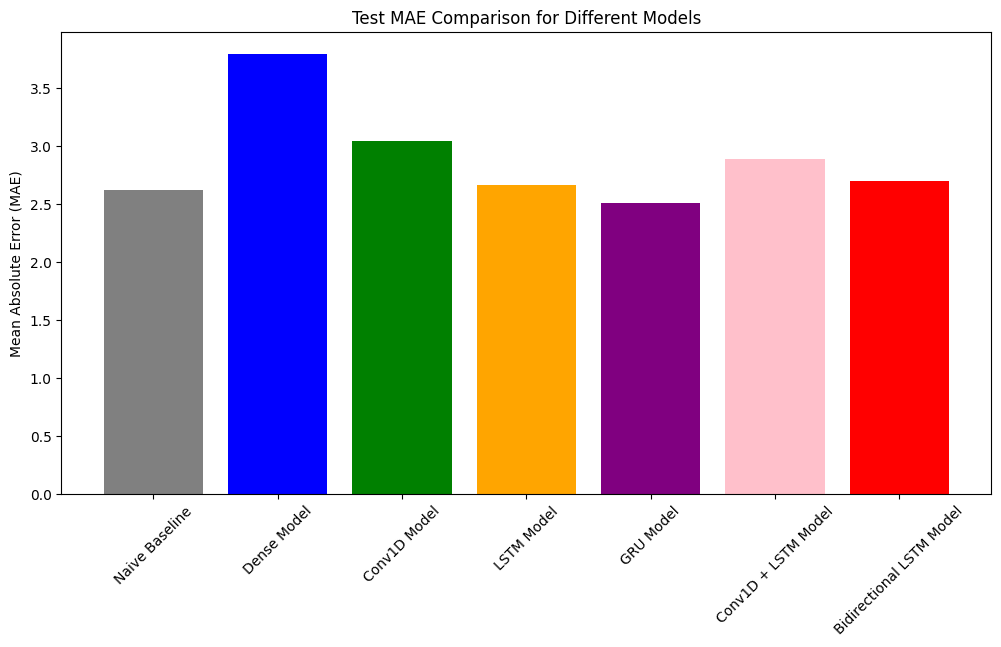

In [30]:
# Collect test MAE values for each model
results = {
    'Naive Baseline': evaluate_naive_baseline(test_dataset, std, mean),
    'Dense Model': dense_model.evaluate(test_dataset, verbose=0)[1],
    'Conv1D Model': conv_model.evaluate(test_dataset, verbose=0)[1],
    'LSTM Model': lstm_model.evaluate(test_dataset, verbose=0)[1],
    'GRU Model': gru_model.evaluate(test_dataset, verbose=0)[1],
    'Conv1D + LSTM Model': conv1d_lstm_model.evaluate(test_dataset, verbose=0)[1],
    'Bidirectional LSTM Model': bidir_lstm_model.evaluate(test_dataset, verbose=0)[1]
}

# Plot the results in a bar chart
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'green', 'orange', 'purple', 'pink', 'red'])
plt.title("Test MAE Comparison for Different Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)
plt.show()

3. Predictions vs. True Values on Test Set for Each Model

This plot shows each model’s predictions alongside the true temperature values, helping visually assess prediction accuracy.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


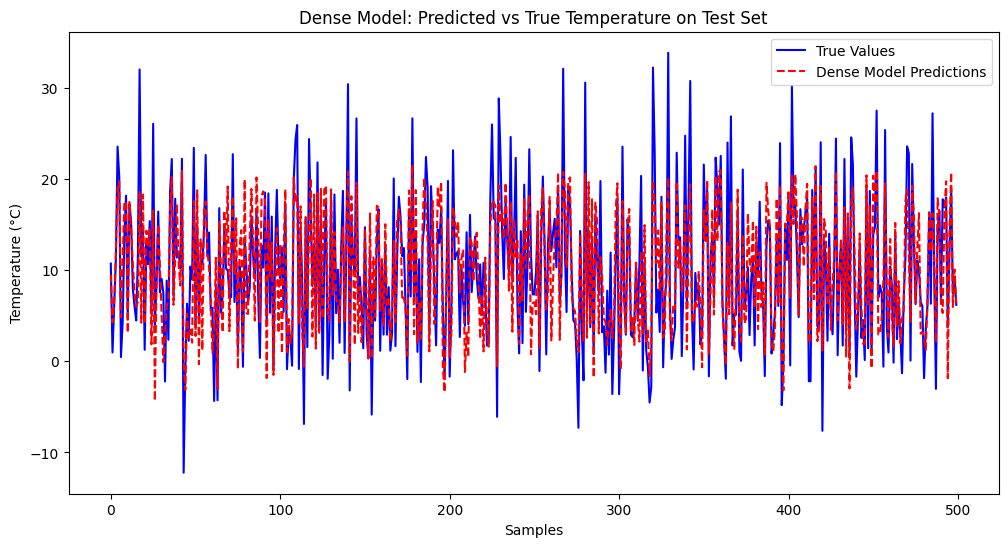

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


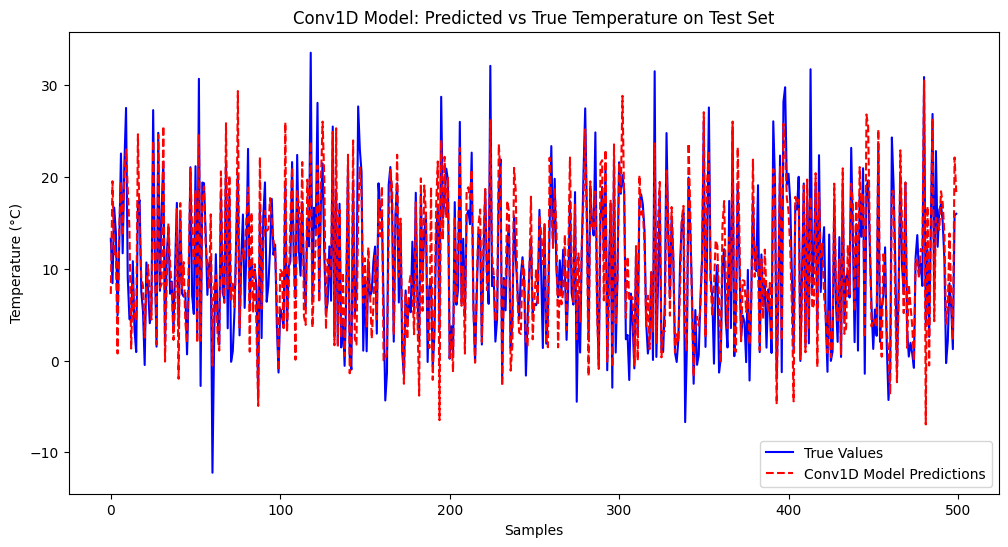

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


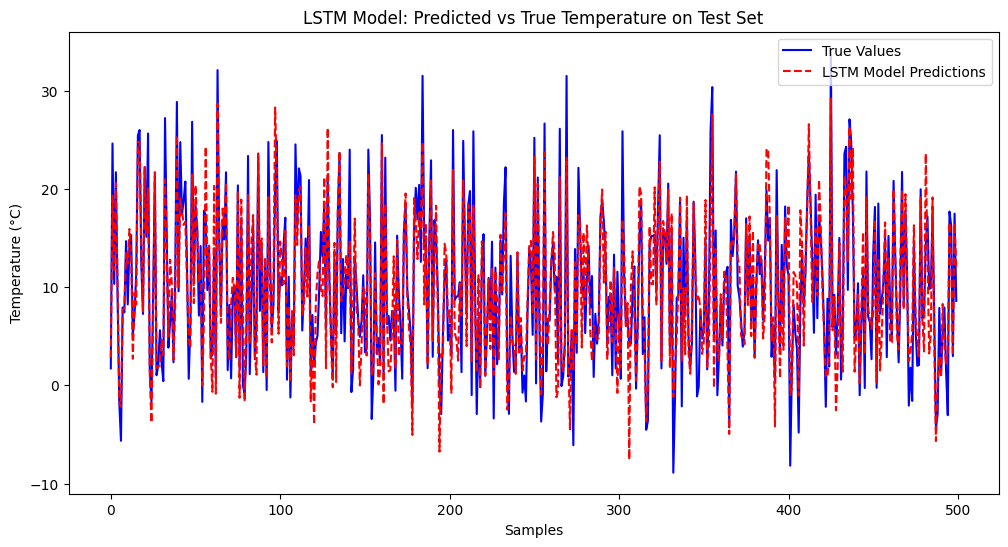

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


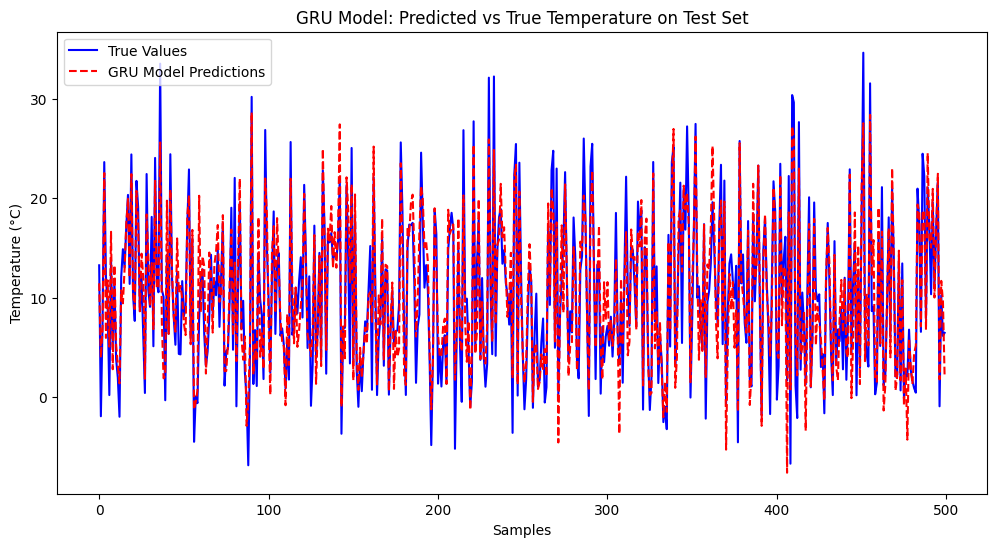

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


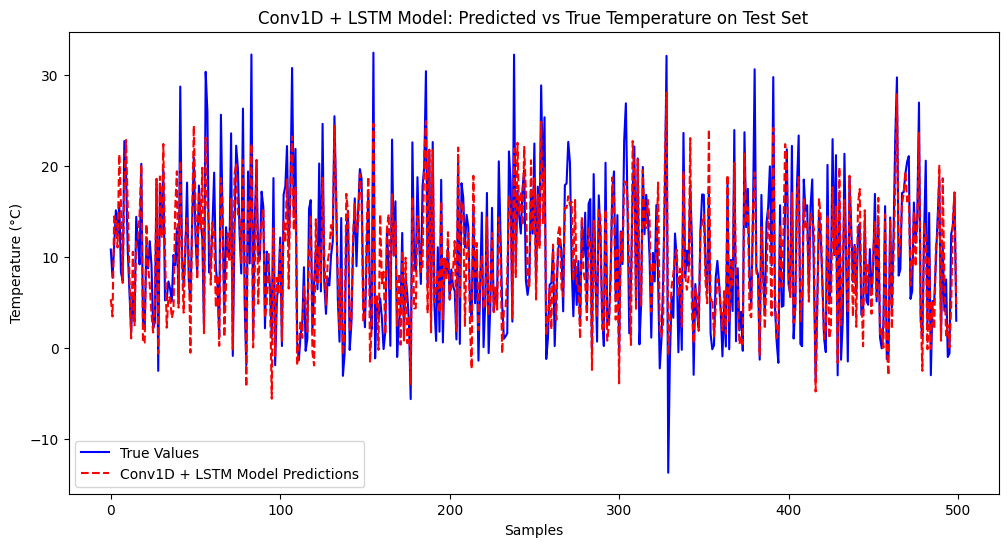

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


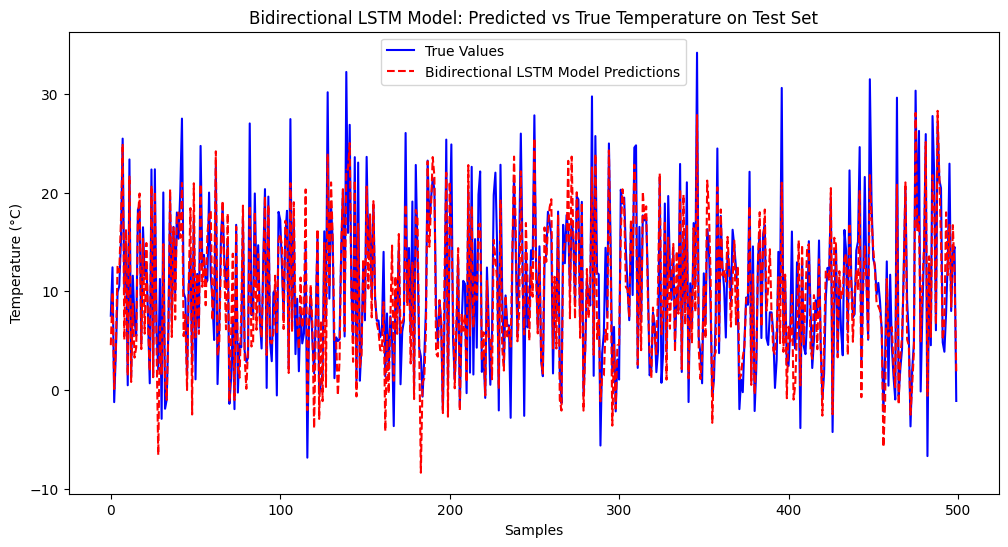

In [32]:
# Function to plot predictions vs true values for a specific model
def plot_predictions(model, dataset, model_name="Model"):
    y_true, y_pred = [], []
    for samples, targets in dataset.take(2):  # Taking only a portion of the test set
        predictions = model.predict(samples)
        y_true.extend(targets.numpy())
        y_pred.extend(predictions.squeeze())

    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:500], label="True Values", color='blue')
    plt.plot(y_pred[:500], label=f"{model_name} Predictions", color='red', linestyle='--')
    plt.title(f"{model_name}: Predicted vs True Temperature on Test Set")
    plt.xlabel("Samples")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()

# Plot predictions for each model
plot_predictions(dense_model, test_dataset, "Dense Model")
plot_predictions(conv_model, test_dataset, "Conv1D Model")
plot_predictions(lstm_model, test_dataset, "LSTM Model")
plot_predictions(gru_model, test_dataset, "GRU Model")
plot_predictions(conv1d_lstm_model, test_dataset, "Conv1D + LSTM Model")
plot_predictions(bidir_lstm_model, test_dataset, "Bidirectional LSTM Model")

405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step
Dense Model Predicted Temperatures (First 10): [ 2.3222306 21.477705  13.194024  17.790625  17.027948   2.1358635
 11.285071   7.717436   1.076328   3.1237383]
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step
Conv1D Model Predicted Temperatures (First 10): [28.82586   17.520462  25.755533  23.947622  12.081502   3.265617
  6.8122363  8.405164   2.228125  24.335411 ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step
LSTM Model Predicted Temperatures (First 10): [ 2.9289746  7.522412  22.046227   3.514274  -2.0630436 16.614927
  7.913239  13.280717  18.232782  10.627844 ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step
Bidirectional LSTM Model Predicted Temperatures (First 10): [ 5.215486  15.695482   4.338426  19.943968  14.630039   5.4260793
 12.401129  17.306053   1.7136093 17.37523  ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step
GRU Model Predicted Temperatures (First 10): [ 5.9409957  9.927651  21.029913   2.08245    8.264275  17.950514
  5.4155817 21.085363  

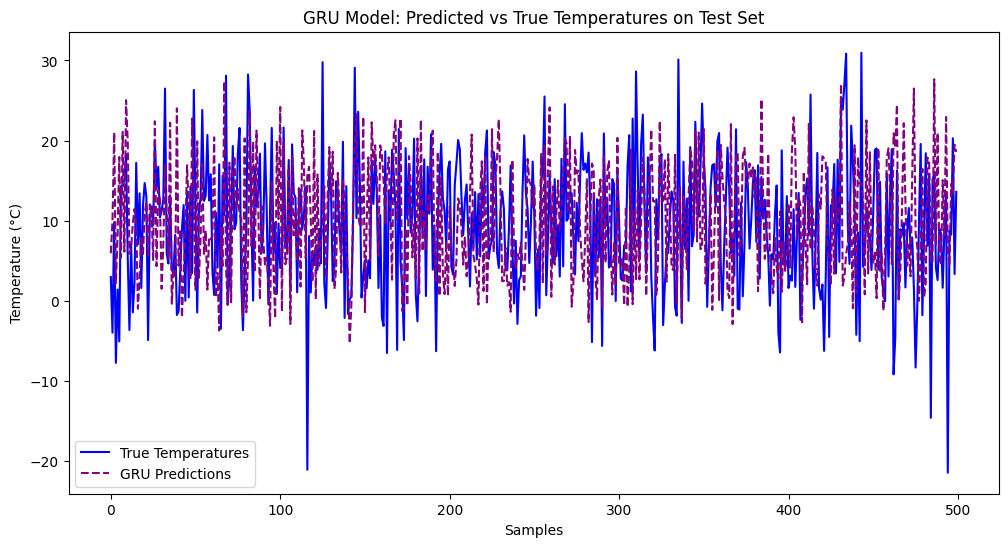

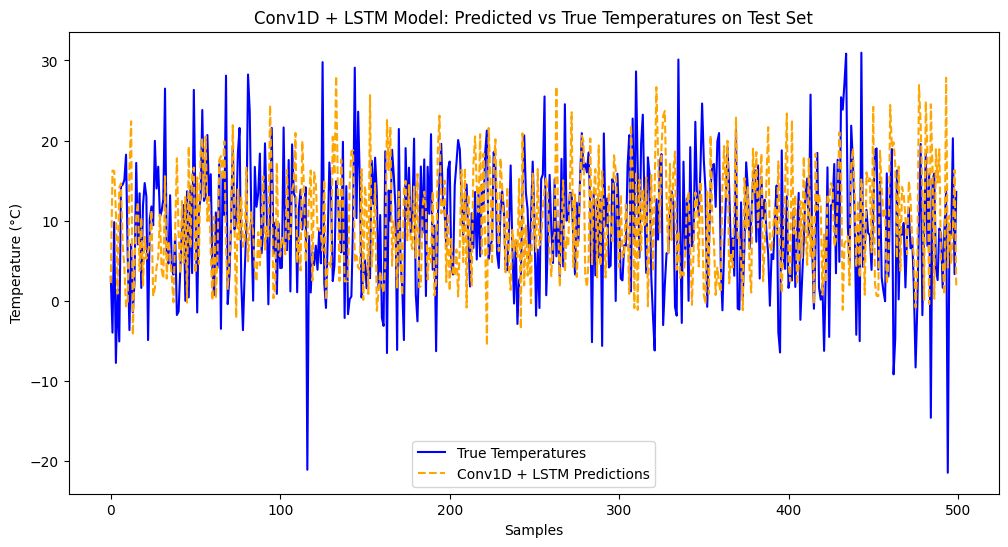

In [35]:
# Generate predictions for each model on the test dataset

# Dense Model
dense_predictions = dense_model.predict(test_dataset)
print("Dense Model Predicted Temperatures (First 10):", dense_predictions[:10].flatten())

# Conv1D Model
conv1d_predictions = conv_model.predict(test_dataset)
print("Conv1D Model Predicted Temperatures (First 10):", conv1d_predictions[:10].flatten())

# LSTM Model
lstm_predictions = lstm_model.predict(test_dataset)
print("LSTM Model Predicted Temperatures (First 10):", lstm_predictions[:10].flatten())

# Bidirectional LSTM Model
bidir_lstm_predictions = bidir_lstm_model.predict(test_dataset)
print("Bidirectional LSTM Model Predicted Temperatures (First 10):", bidir_lstm_predictions[:10].flatten())
# Assuming 'gru_model' and 'conv1d_lstm_model' are the trained GRU and Conv1D + LSTM models

# Generate predictions on the test set for GRU model
gru_predictions = gru_model.predict(test_dataset)
print("GRU Model Predicted Temperatures (First 10):", gru_predictions[:10].flatten())

# Generate predictions on the test set for Conv1D + LSTM model
conv1d_lstm_predictions = conv1d_lstm_model.predict(test_dataset)
print("Conv1D + LSTM Model Predicted Temperatures (First 10):", conv1d_lstm_predictions[:10].flatten())

# Optional: Plot the true vs predicted values for both models to visually compare
import matplotlib.pyplot as plt

# Plot GRU Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label="True Temperatures", color="blue")
plt.plot(gru_predictions[:500], label="GRU Predictions", color="purple", linestyle="--")
plt.title("GRU Model: Predicted vs True Temperatures on Test Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Plot Conv1D + LSTM Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label="True Temperatures", color="blue")
plt.plot(conv1d_lstm_predictions[:500], label="Conv1D + LSTM Predictions", color="orange", linestyle="--")
plt.title("Conv1D + LSTM Model: Predicted vs True Temperatures on Test Set")
plt.xlabel("Samples")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

**Summary**

In this Time Series project, I have tested various neural network models to forecast temperature, starting with simple Dense layers and advancing to specialized architectures like LSTM, GRU, Conv1D, and hybrids. Each model’s accuracy was evaluated using Mean Absolute Error (MAE) on validation and test sets to identify the most effective approach for time-series data.

**Key Findings**

	1.	Dense and Conv1D Models Underperformed: Both models struggled with capturing sequential patterns, with Dense layers showing the highest error. Conv1D performed better but still fell short of sequence-specific models.
	2.	LSTM and GRU Excelled: LSTM and GRU models, known for handling time-series data, significantly improved accuracy. The GRU model, in particular, achieved the lowest test MAE, likely due to its simpler structure, which prevents overfitting.
	3.	Conv1D + LSTM Hybrid Was Strong: This hybrid model effectively combined local and sequential learning, performing on par with GRU, although with added complexity.
	4.	Bidirectional LSTM Didn’t Help: Processing data in both directions increased the model’s complexity without improving accuracy, leading to overfitting and a slightly higher error.

Conclusion

The GRU model emerged as the top performer due to its balance of simplicity and accuracy. The Conv1D + LSTM hybrid was also effective but more complex. This analysis highlights the value of recurrent models like GRU for time-series forecasting, where capturing sequential dependencies is essential. Future work could explore fine-tuning GRU or adding attention mechanisms to enhance predictive performance.

**For Knitting the .ipynb file to html File**

In [38]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
#!ls /content/drive/MyDrive


'Colab Notebooks'  'dogs-vs-cats.zip (Unzipped Files)'	 Himalay_Time_series.ipynb
 dogs-vs-cats.zip   Himalay_Time_series-2.ipynb		 jena_climate_2009_2016.csv


In [41]:
#file_path = '/content/drive/MyDrive/Himalay_Time_series-2.ipynb'

In [46]:
!#gdown 'https://drive.google.com/file/d/1uBAeLMnSIHXKMHgOZ6a8eOg2Oknp0SLe/view?usp=sharing'

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1uBAeLMnSIHXKMHgOZ6a8eOg2Oknp0SLe
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1uBAeLMnSIHXKMHgOZ6a8eOg2Oknp0SLe/view?usp=sharing
To: /content/view?usp=sharing
91.8kB [00:00, 57.4MB/s]


In [49]:
# Copy the notebook to the current working directory (optional)
!cp /content/drive/MyDrive/Himalay_Time_series-2.ipynb .

# Convert to HTML and download
!jupyter nbconvert --to html Himalay_Time_series-2.ipynb
from google.colab import files
files.download('Himalay_Time_series-2.html')

[NbConvertApp] Converting notebook Himalay_Time_series-2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 16 image(s).
[NbConvertApp] Writing 5254301 bytes to Himalay_Time_series-2.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>